# Explore here

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import plotly.io as pio

In [2]:
data = pd.read_csv("../data/Lake_Bilancino.csv")
data.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


In [4]:
data.isna().sum()

Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64

In [5]:
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
data = data.dropna(subset=["Date"])
data = data.sort_values("Date")

# Renombrar columnas para Prophet
data = data[["Date", "Rainfall_S_Piero"]].rename(columns={"Date": "ds", "Rainfall_S_Piero": "y"})

data = data.drop_duplicates(subset=["ds"], keep="first")
data = data.set_index("ds").asfreq("D")
data = data.dropna()

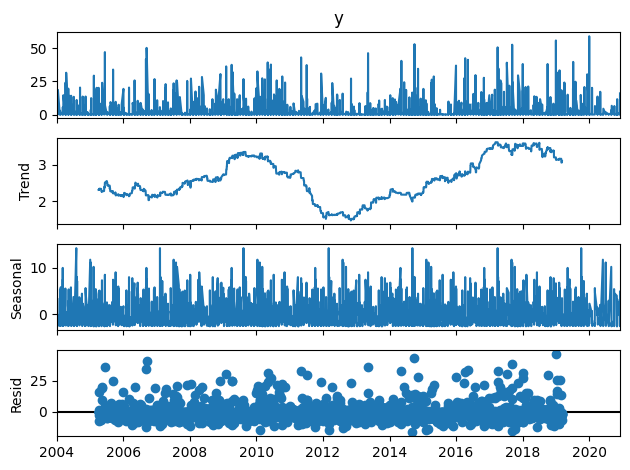

In [6]:
result = seasonal_decompose(data["y"], model='additive', period=365)
result.plot()
plt.show()

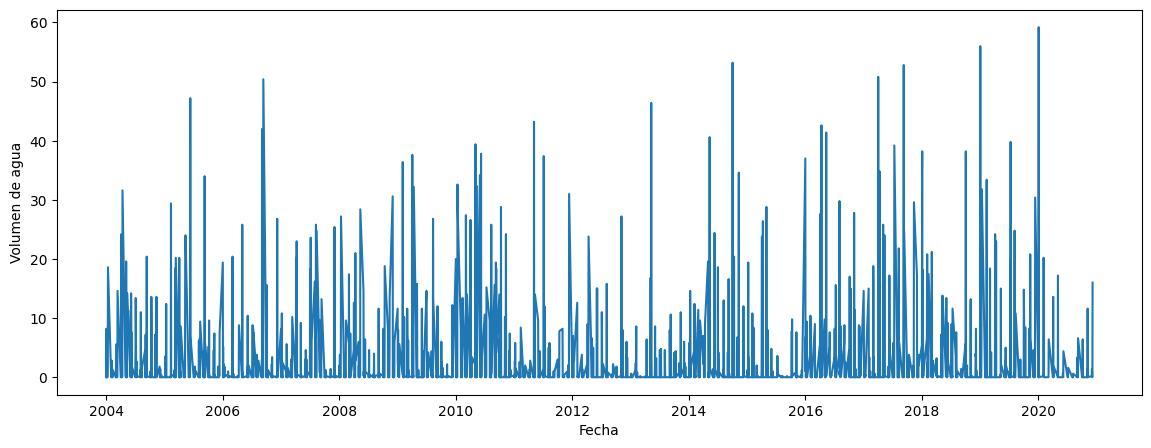

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(data.index, data["y"])
plt.xlabel("Fecha")
plt.ylabel("Volumen de agua")
plt.show()


In [8]:
adf = adfuller(data["y"])
print(f"ADF Statistic: {adf[0]}")
print(f"p-value: {adf[1]}")
for key, val in adf[4].items():
    print(f"Critical Value ({key}): {val}")


ADF Statistic: -10.494235528312776
p-value: 1.126329696907925e-18
Critical Value (1%): -3.433120384218136
Critical Value (5%): -2.8627639098437925
Critical Value (10%): -2.567421539882828


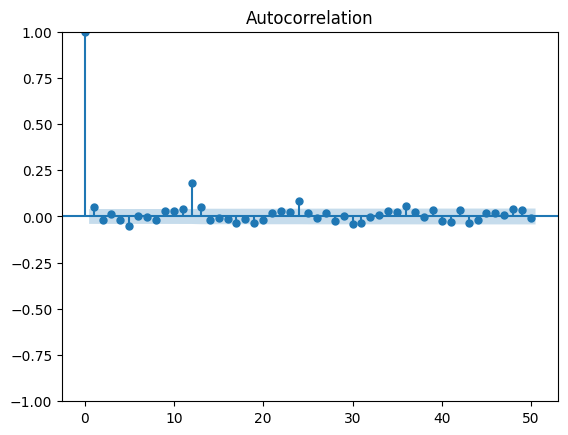

In [9]:
plot_acf(data["y"], lags=50)
plt.show()

In [10]:
data = data.reset_index()

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,
    changepoint_range=0.95
)

model.add_seasonality(name='mensual', period=30.5, fourier_order=5)

model.fit(data)

16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing


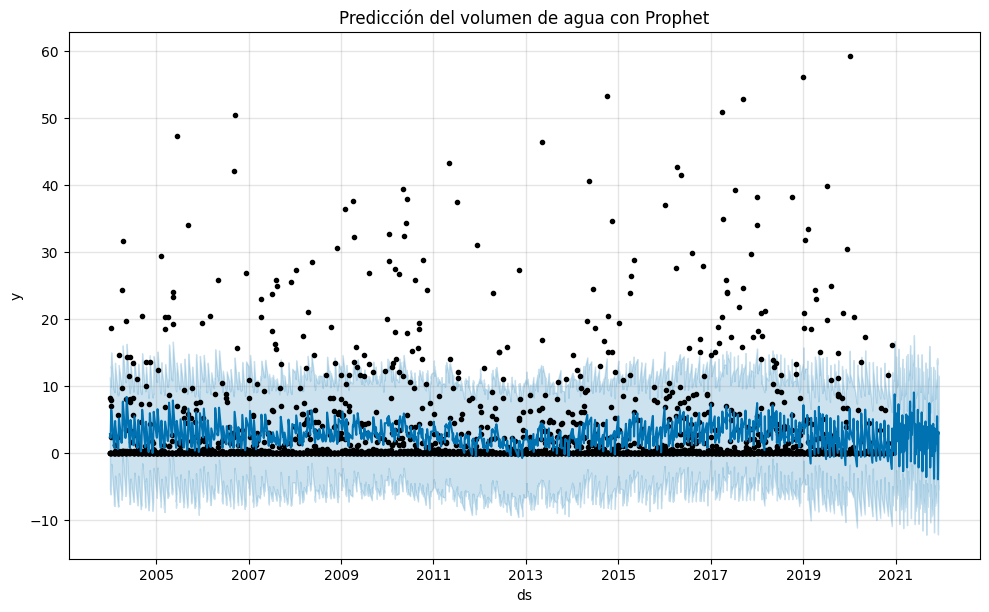

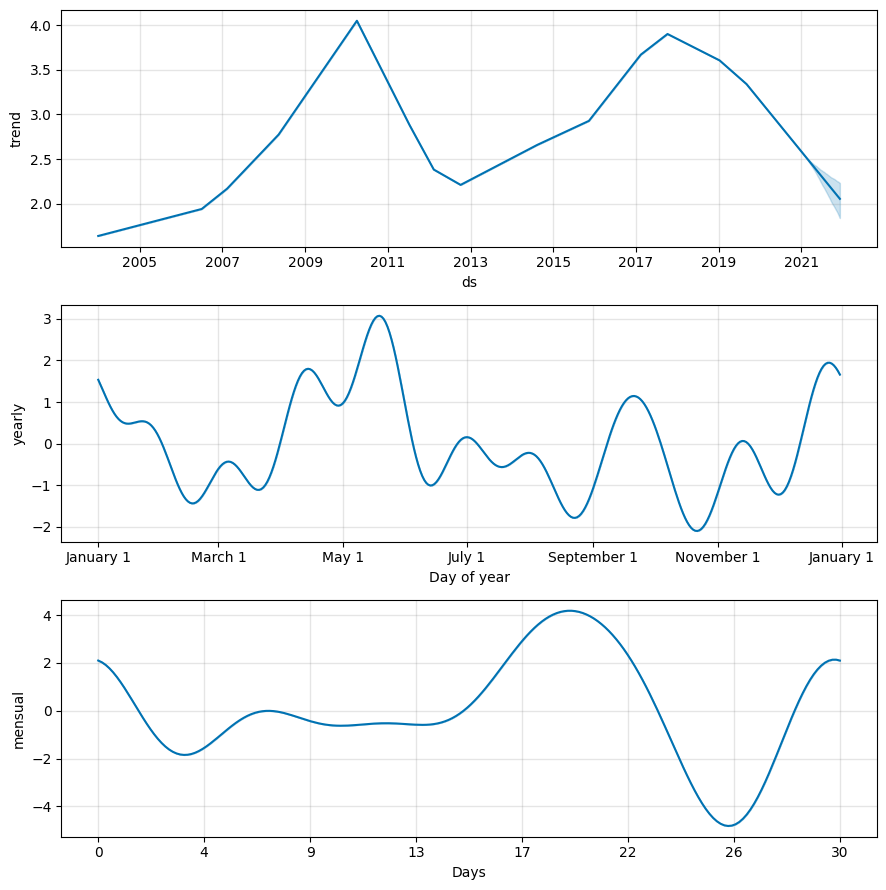

In [11]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("Predicción del volumen de agua con Prophet")
plt.show()

model.plot_components(forecast)
plt.show()

In [13]:
from pickle import dump
with open('modelo.pkl', 'wb') as file:
    dump(model, file)